<a href="https://colab.research.google.com/github/YoonJiHwan98/dacon_code/blob/main/gAs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#라이브 러리 폰트



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
!git clone https://github.com/YoonJiHwan98/TIL.git

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/TAVE 머신러닝 스터디/Gas/한국가스공사_시간별 공급량_20181231.csv',encoding = 'cp949')
test = pd.read_csv('/content/drive/MyDrive/TAVE 머신러닝 스터디/Gas/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/TAVE 머신러닝 스터디/Gas/sample_submission.csv')

In [ ]:
data1 = data.copy()


# 데이터 전처리

## 공휴일 추가


In [ ]:
data1['연월일'] = pd.to_datetime(data1['연월일'])

In [ ]:
data1['year'] = data1['연월일'].dt.year
data1['month'] = data1['연월일'].dt.month
data1['day'] = data1['연월일'].dt.day
data1['weekday'] = data1['연월일'].dt.weekday

In [ ]:
# %%
# 휴일 목록 
hol = '''
20130101
20130211
20130301
20130517
20130606
20130815
20130918
20130919
20130920
20131003
20131009
20131225
20140101
20140130
20140131
20140505
20140506
20140604
20140606
20140815
20140908
20140909
20140910
20141003
20141009
20141225
20150101
20150218
20150219
20150220
20150505
20150525
20150814
20150928
20150929
20151009
20151225
20160101
20160208
20160209
20160210
20160301
20160413
20160505
20160506
20160606
20160815
20160914
20160915
20160916
20161003
20170127
20170130
20170301
20170503
20170505
20170509
20170606
20170815
20171002
20171003
20171004
20171005
20171006
20171009
20171225
20180101
20180215
20180216
20180301
20180507
20180522
20180606
20180613
20180815
20180924
20180925
20180926
20181003
20181009
20181225
20190101
20190204
20190205
20190206
20190301
'''
hol
#%%
holiday = hol.split('\n')
holiday.pop(0)
holiday.pop(-1)
for i in range(len(holiday)) :
  holiday[i] = holiday[i][0:4] + '-' + holiday[i][4:6] + '-' + holiday[i][6:8]

holiday
# %%
data1[data1['연월일'].isin(holiday)]
data1['휴일'] = 0
data1.loc[data1['연월일'].isin(holiday), '휴일'] = 1
data1.loc[(data1['weekday']==5) | (data1['weekday']==6),'휴일'] = 1

In [ ]:
data1

In [ ]:
data1['구분'] = data1['구분'].astype('category')
data1['구분'] = data1['구분'].map({'A' : '1','B' : '2','C' : '3','D' : '4','E' : '5','G' : '6','H' : '7'})
data1['weekday'] = data1['weekday'].astype('category')
data1['휴일'] = data1['휴일'].astype('category')


In [ ]:
data1

## 이상치 처리

In [ ]:
 data1['공급량'] = data1['공급량'].apply(lambda x : None if x < 10 else x) # 10 보다 작은 이상치들은 Nan 처리

In [ ]:
# 그 전 값으로 채우는 방식과 그냥 삭제하는 방식
df_fill = data1.fillna(method='ffill')
df_drop = data1.dropna()

In [ ]:
df_drop

In [ ]:
#pred_df.groupby('DateTime')['yhat'].mean().reset_index(name = 'pred').head()


In [ ]:
!pip install optuna

In [ ]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder

In [ ]:
X = df_drop[['시간','구분','year','month','day','weekday','휴일']]
y = df_drop['공급량']

In [ ]:
X

In [ ]:
one_hot_cols = X[['weekday','구분','휴일']].columns.tolist()
X_enc = pd.get_dummies(X, columns=one_hot_cols,drop_first=True)
X_enc

In [ ]:
X.info()

# XGBOOST


## 데이터 전처리

In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/TAVE 머신러닝 스터디/Gas/gas_train.csv')
test = pd.read_csv('/content/drive/MyDrive/TAVE 머신러닝 스터디/Gas/gas_test.csv')

In [ ]:
test.drop(columns = ['Unnamed: 0','연월일'],inplace = True)

In [ ]:
train

In [ ]:
test

In [ ]:
X = train[['Year','Month','Day','Weekday','시간','구분','휴일','기온']]
y = train['공급량']

In [ ]:
one_hot_cols = train[['Weekday','구분','휴일']].columns.tolist()
X_enc = pd.get_dummies(X, columns=one_hot_cols,drop_first=True)
X_enc

In [ ]:
test = test[['Year','Month','Day','Weekday','시간','구분','휴일','기온']]
one_hot_cols = test[['Weekday','구분','휴일']].columns.tolist()
test = pd.get_dummies(test, columns=one_hot_cols,drop_first=True)
test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, shuffle=True, random_state=2021)

## XGB 모델링

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=1000, tree_method='gpu_hist')
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50,verbose=False)


In [ ]:
base_pred = model_xgb.predict(X_test)
base_pred

In [ ]:
MAPE(y_test, base_pred)

In [ ]:
hyperparam = {'lambda': 0.2116482513616873, 'alpha': 0.2545592065777445, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.018, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 36}

model_xgb_tued = xgb.XGBRegressor(max_depth = 20 ,learning_rate=0.018, n_estimators=1000, colsample_bytree = 0.9,random_state = 24 , min_child_weight = 36, sub_sample = 0.7 , tree_method='gpu_hist')

model_xgb_tued.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50,verbose=False)



In [ ]:
base_tuned = model_xgb_tued.predict(X_test)
base_tuned

In [ ]:
MAPE(y_test,base_tuned)

In [ ]:
#model_xgb_tued(test)

## CV

## 파라미터 튜닝


In [ ]:
!pip install optuna

In [ ]:
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [ ]:
def objective(trial,data=X_enc,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(X_enc, y, test_size=0.25,random_state=42)
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 100,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=75,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = MAPE(test_y, preds)
    
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
hyperparam50 = {'lambda': 0.8096315611323108, 'alpha': 0.11425328658197806, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 151}

In [ ]:
hyperparam50 = {'lambda': 0.8096315611323108, 'alpha': 0.11425328658197806, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 151}

model_xgb_tued50 = xgb.XGBRegressor(max_depth = 9 ,learning_rate=0.02, n_estimators=1000, colsample_bytree = 0.9,random_state = 24 , min_child_weight = 151, sub_sample = 0.7 , tree_method='gpu_hist')
 reg_alpha=0.11425328658197806, reg_lambda=0.8096315611323108
model_xgb_tued50.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50,verbose=False)

In [ ]:
pred_tuned50 = model_xgb_tued50.predict(X_test)
pred_tuned50

In [ ]:
MAPE(y_test,pred_tuned50)

In [ ]:
hyperparam100 = {'lambda': 0.03383332279686637, 'alpha': 0.0019474261185779493, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 17}

model_xgb_tued100 = xgb.XGBRegressor(max_depth = 13 ,learning_rate=0.02, n_estimators=1000, colsample_bytree = 0.9,random_state = 24 , min_child_weight = 17, sub_sample = 0.7 , reg_lambda = 0.03383332279686637, reg_alpha = 0.0019474261185779493, tree_method='gpu_hist')

In [ ]:
model_xgb_tued100.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50,verbose=False)

In [ ]:
pred_tuned100 = model_xgb_tued100.predict(X_test)
MAPE(y_test,pred_tuned100)

## K-Fold

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle = True, random_state=0)
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate


In [ ]:
scores = cross_val_score(model_xgb , 
                        X_enc , 
                        y ,
                        cv=kfold,
                        n_jobs=-1,
                        scoring='neg_mean_absolute_percentage_error')

# 최종적으로 평균을 내어 정확도를 간단히 한다.
print('교차 검증별 정확도:',np.round(scores * -1, 4))
print('평균 검증 정확도:', np.round(np.mean(scores* -1), 4))

In [ ]:
scores_tued50 = cross_val_score(model_xgb_tued50 , 
                        X_enc , 
                        y ,
                        cv=kfold,
                        n_jobs=-1,
                        scoring='neg_mean_absolute_percentage_error')

# 최종적으로 평균을 내어 정확도를 간단히 한다.
print('교차 검증별 정확도:',np.round(scores_tued50 * -1, 4))
print('평균 검증 정확도:', np.round(np.mean(scores_tued50* -1), 4))

In [ ]:
scores_tued = cross_val_score(model_xgb_tued , 
                        X_enc , 
                        y ,
                        cv=kfold,
                        n_jobs=-1,
                        scoring='neg_mean_absolute_percentage_error')

# 최종적으로 평균을 내어 정확도를 간단히 한다.
print('교차 검증별 정확도:',np.round(scores_tued * -1, 4))
print('평균 검증 정확도:', np.round(np.mean(scores_tued* -1), 4))

In [ ]:
test


# Prophet



In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

https://dacon.io/codeshare/2326

https://dacon.io/codeshare/2327?page&dtype&ptype

In [ ]:
#data['연월일시'] = 
data['시간'] = data['시간'].astype(str)

In [ ]:
data['시간'] = data['시간'].map({'1' : '01','2' : '02','3' : '03','4' : '04','5' : '05','6' : '06','7' : '07','8' : '08','9' : '09','10' : '10','11' : '11','12' : '12','13' : '13','14' : '14','15' : '15','16' : '16','17' : '17','18' : '18','19' : '19','20' : '20','21' : '21','22' : '22','23' : '23','24' : '00'})

In [ ]:
data['시간'] = data['시간'].astype(str)

In [ ]:
#data['연월일시'] = data['연월일'] + '-' + data['시간']
data

In [ ]:
data1['연월일'] = data1['연월일'].astype(str)
#data1['연월일시'] = data1['연월일'] + ' ' + data1['시간']

In [ ]:
data1['연월일시'] = data1['연월일시'].apply(lambda x : pd.to_datetime(x.split()[0]) + datetime.timedelta(days=1) if x.split()[1] == '24' else x)
#data1['연월일시'] = pd.to_datetime(data1['연월일시'])
data1

In [ ]:
df_a = data1[data1['구분'] == 'A']
df_b = data1[data1['구분'] == 'B']
df_c = data1[data1['구분'] == 'C']
df_d = data1[data1['구분'] == 'D']
df_g = data1[data1['구분'] == 'G']
df_h = data1[data1['구분'] == 'H']
df_e = data1[data1['구분'] == 'E']


In [ ]:
#df['time'].apply(lambda x: pd.to_datetime(x.split()[0]) + timedelta)

In [ ]:
data1['구분'].unique()

In [ ]:
sns.lineplot(data=df_h , x = '연월일시',y = '공급량')
plt.show()

In [ ]:
sns.lineplot(data=df_e , x = '연월일시',y = '공급량')
plt.show()

In [ ]:
df_c['공급량'].min()

In [ ]:
#sns.lineplot(data=df_h , x = '연월일시',y = '공급량')
plt.show()

In [ ]:
df_a[['ds','y']] = df_a[['연월일시','공급량']]
df_b[['ds','y']] = df_b[['연월일시','공급량']]
df_c[['ds','y']] = df_c[['연월일시','공급량']]
df_d[['ds','y']] = df_d[['연월일시','공급량']]
df_e[['ds','y']] = df_e[['연월일시','공급량']]
df_h[['ds','y']] = df_h[['연월일시','공급량']]
df_g[['ds','y']] = df_g[['연월일시','공급량']]

In [ ]:
train_a = df_a[['ds','y']]
train_b = df_b[['ds','y']]
train_c = df_c[['ds','y']]
train_d = df_d[['ds','y']]
train_e = df_e[['ds','y']]
train_h = df_h[['ds','y']]
train_g = df_g[['ds','y']]

In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet
!pip install statsmodels==0.11.1
!pip install fbprophet==0.7.1

In [ ]:
from fbprophet import Prophet

model_a =Prophet() 
model_a.fit(train_a) 
future_A = model_a.make_future_dataframe(periods=2161, freq='H') 
forecast_A = model_a.predict(future_A)

In [ ]:
model_b =Prophet() 
model_b.fit(train_b) 
future_b = model_b.make_future_dataframe(periods=2161, freq='H') 
forecast_b = model_a.predict(future_b)

In [ ]:
model_c = Prophet() 
model_c.fit(train_c) 
future_c = model_c.make_future_dataframe(periods=2161, freq='H') 
forecast_c = model_c.predict(future_c)

In [ ]:
model_d =Prophet() 
model_d.fit(train_d) 
future_d = model_d.make_future_dataframe(periods=2161, freq='H') 
forecast_d = model_d.predict(future_d)

In [ ]:
model_e =Prophet() 
model_e.fit(train_e) 
future_e = model_e.make_future_dataframe(periods=2161, freq='H') 
forecast_e = model_e.predict(future_e)

In [ ]:
model_h =Prophet() 
model_h.fit(train_h) 
future_h = model_h.make_future_dataframe(periods=2161, freq='H') 
forecast_h = model_h.predict(future_h)

In [ ]:
model_g =Prophet() 
model_g.fit(train_g) 
future_g = model_g.make_future_dataframe(periods=2161, freq='H') 
forecast_g = model_g.predict(future_g)

In [ ]:
pred_a = forecast_A.loc[52585:,'yhat']
pred_b = forecast_b.loc[52585:,'yhat']
pred_c = forecast_c.loc[52585:,'yhat']
pred_d = forecast_d.loc[52585:,'yhat']
pred_e = forecast_e.loc[52585:,'yhat']
pred_h = forecast_h.loc[52585:,'yhat']
pred_g = forecast_g.loc[52585:,'yhat']

In [ ]:
#testA = test[test['일자|시간|구분'].str.contains('A')]
#testB = test[test['일자|시간|구분'].str.contains('B')]
#testC = test[test['일자|시간|구분'].str.contains('C')]
#testD = test[test['일자|시간|구분'].str.contains('D')]
#testE = test[test['일자|시간|구분'].str.contains('E')]
#testG = test[test['일자|시간|구분'].str.contains('G')]
#testH = test[test['일자|시간|구분'].str.contains('H')]

In [ ]:
#pred_a = pred_a.reset_index()
pred_a['yhat']

In [ ]:
pred_a

In [ ]:
#total = 
total = pd.concat([pred_a,pred_b,pred_c,pred_d,pred_e,pred_h,pred_g])

In [ ]:
#total.to_frame().reset_index()['yhat']

In [ ]:
submission['공급량'] = total.to_frame().reset_index()['yhat']
submission

# 정확도 측정 / submission 제출 

In [ ]:
#submission.to_csv('/content/drive/MyDrive/TAVE 머신러닝 스터디/Gas/211105_1.csv', index = False,encoding = 'cp949')


In [ ]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [ ]:
test

In [ ]:
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday
test

In [ ]:
test[test['일자'].isin(holiday)]
test['휴일'] = 0
test.loc[test['일자'].isin(holiday), '휴일'] = 1
test.loc[(test['weekday']==5) | (test['weekday']==6),'휴일'] = 1

In [ ]:
test['구분'] = test['구분'].astype('category')
test['weekday'] = test['weekday'].astype('category')
test['구분'] = test['구분'].map({'A' : '1','B' : '2','C' : '3','D' : '4','E' : '5','G' : '6','H' : '7'})
test['휴일'] = test['휴일'].astype('category')
test['시간'] = test['시간'].astype('category')
test['year'] = test['year'].astype('category')
test['month'] = test['month'].astype('category')
test['day'] = test['day'].astype('category')


In [ ]:
#test[['시간','구분','year','month','day','weekday','휴일']]

one_hot_cols = test[['시간','구분','year','month','day','weekday','휴일']].columns.tolist()
test_enc = pd.get_dummies(test[['시간','구분','year','month','day','weekday','휴일']], columns=one_hot_cols,drop_first=True)
test_enc


In [ ]:
submission.head(10)

In [ ]:
test['공급량'] = total.to_frame().reset_index()['yhat']

In [ ]:
test.to_csv('/content/drive/MyDrive/TAVE 머신러닝 스터디/Gas/211105_2.csv', index = False,encoding = 'cp949')

In [ ]:
def nmae(true_df, pred_df):
    target_idx = true_df.iloc[:,0]
    pred_df = pred_df[pred_df.iloc[:,0].isin(target_idx)]
    pred_df = pred_df.sort_values(by=[pred_df.columns[0]], ascending=[True])
    true_df = true_df.sort_values(by=[true_df.columns[0]], ascending=[True])
    true = true_df.iloc[:,1].to_numpy()
    pred = pred_df.iloc[:,1].to_numpy()
    
    score = np.mean((np.abs(true-pred))/true)
    
    return score

In [ ]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test))
    

In [ ]:
submission

In [ ]:
#pred_tued50 = model_xgb_tued50.predict(test)
pred_tued = model_xgb_tued.predict(test)
pred_tued100 = model_xgb_tued100.predict(test)

In [ ]:
nmae(y_test,predict_c)

In [ ]:
submission['공급량'] = pred_tued50

In [ ]:
pred_tued = model_xgb_tued.predict(test)
submission['공급량'] = pred_tued
submission.to_csv('/content/drive/MyDrive/TAVE 머신러닝 스터디/Gas/211128_11.csv',index = False)

In [ ]:
submission.to_csv('/content/drive/MyDrive/TAVE 머신러닝 스터디/Gas/211128.csv',index = False)

#Pycaret

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.regression import *

In [ ]:
df_py = pd.read_csv('/content/drive/MyDrive/TAVE 머신러닝 스터디/Gas/gas_train.csv')
test_py = pd.read_csv('/content/drive/MyDrive/TAVE 머신러닝 스터디/Gas/gas_test.csv')

In [ ]:
df_py = df_py.drop(columns=['Unnamed: 0','Unnamed: 0.1','연월일','key','WeekNum'])


In [ ]:
df_py

In [ ]:
reg = setup(data=df_py,
            target='공급량',
            session_id = 201,
            numeric_imputation = 'mean',
            fold_shuffle = True,
            numeric_features=list(df_py[['Year','Month','Day','시간','기온']].columns),
            categorical_features = ['구분','Weekday','휴일'],
            ignore_low_variance = True,
            combine_rare_levels = True, rare_level_threshold = 0.05,
            remove_multicollinearity = True, multicollinearity_threshold = 0.90,
            normalize = True,
            silent= True,
            use_gpu = True)

In [ ]:
top3 = compare_models(n_select = 3 , sort = 'MAPE')

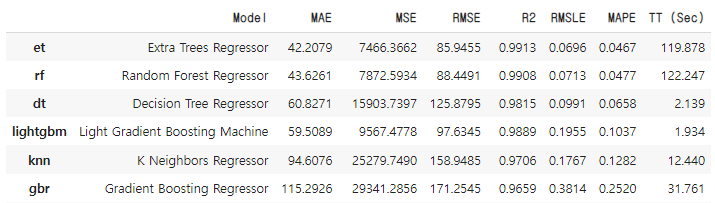

In [ ]:
blended_l = blend_models(estimator_list= top3, fold=5, optimize='MAPE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)


In [ ]:

pred_esb_l = predict_model(final_model_l, test_data) 

In [ ]:
pred_holdout